## XGBOOST SIN UNIRED

In [1]:
path1 = '/gpfs/fs01/user/s57f-73edb3521eee1d-79e3f294add4/notebook/data2/bloqueo2balanceado.csv'
path2 = '/gpfs/fs01/user/s57f-73edb3521eee1d-79e3f294add4/notebook/data2/unicard2balanceado.csv'
path3 = '/gpfs/fs01/user/s57f-73edb3521eee1d-79e3f294add4/notebook/data2/muestra2desbalanceada.csv'

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

bloq2bal = pd.read_csv(path1, index_col=False, header=0, sep='\t')
unic2bal = pd.read_csv(path2, index_col=False, header=0, sep='\t')
mues2bal = pd.read_csv(path3, index_col=False, header=0, sep='\t')

# DETERMINACIÓN DE PAGO BLOQUEADOS

In [3]:
pd_boost = bloq2bal

In [4]:
pd_boost.head()

,CUSTOMER_ID,std_pago_unired,max_pago_unired,avg_pago_unired,pago_unired_mensual,avg_dia_pago_unired,max_dia_pago_unired,min_dia_pago_unired,avg_uso_tarjeta,PAYMENT_MEAN_ID,...,std_pago_retail_mensual,SPEND_AMT,DISCOUNT_AMT,GENDER,EDAD,MOBILE_CONTACTABILITY,EMAIL_CONTACTABILITY,GSE,CIVIL_STATUS,bloqueo
0,14295828,34786.587006,135466,54942.416667,659309,5.089003,10.153817,0.707107,0.250000,0,...,19159.363619,260589,23785,FEMENINO,60,1,1,C3,CASADO,0
1,30174068,22804.835996,97050,50127.857143,350895,5.595878,6.363961,4.949747,0.142857,0,...,5602.529458,29387,1633,FEMENINO,59,1,0,E,DIVORCIADO,1
2,54612656,4587.755442,43850,38700.000000,116100,2.819995,4.932883,0.707107,0.000000,0,...,23359.003782,218009,22955,FEMENINO,42,1,0,C3,DIVORCIADO,0
3,99841158,24316.463764,77890,39529.000000,395290,10.563605,10.563605,10.563605,0.005102,0,...,56429.884905,1037580,247719,FEMENINO,51,1,0,E,CASADO,0
4,70026320,28030.667045,104700,63497.000000,317485,9.364604,11.150486,7.778175,0.477157,1,...,38881.129212,1100191,128563,MASCULINO,48,1,0,C3,SOLTERO,0


In [5]:
## One Hot Encoder para GSE
pd_boost = pd.get_dummies(pd_boost, columns=["GSE"])

In [6]:
## One Hot Encoder para CIVIL_STATUS
pd_boost = pd.get_dummies(pd_boost, columns=["CIVIL_STATUS"])

In [7]:
## Reemplazamos por diccionario el Genero
dict_GEN = {"GENDER":{"FEMENINO":0, "MASCULINO":1}}
pd_boost.replace(dict_GEN, inplace=True)

In [8]:
## Reemplazamos todos los nan por ceros
name_col  = list(pd_boost)

for name in name_col:
    if name != 'CUSTOMER_ID':
        error = pd_boost[pd_boost[name].isnull() == True]
        if len(error) > 0:
            pd_boost[name].fillna(0, inplace=True)

In [9]:
name_col

['CUSTOMER_ID',
 'std_pago_unired',
 'max_pago_unired',
 'avg_pago_unired',
 'pago_unired_mensual',
 'avg_dia_pago_unired',
 'max_dia_pago_unired',
 'min_dia_pago_unired',
 'avg_uso_tarjeta',
 'PAYMENT_MEAN_ID',
 'avg_pago_retail_mensual',
 'max_pago_retail_mensual',
 'std_pago_retail_mensual',
 'SPEND_AMT',
 'DISCOUNT_AMT',
 'GENDER',
 'EDAD',
 'MOBILE_CONTACTABILITY',
 'EMAIL_CONTACTABILITY',
 'bloqueo',
 'GSE_ABC1',
 'GSE_C2',
 'GSE_C3',
 'GSE_D',
 'GSE_E',
 'CIVIL_STATUS_CASADO',
 'CIVIL_STATUS_DIVORCIADO',
 'CIVIL_STATUS_SOLTERO',
 'CIVIL_STATUS_VIUDO']

## MODELO XGBOOST

## XGBOOST CON CROSSVALIDATION

In [10]:
## Definimos vectores X e Y 
Y = pd_boost['bloqueo'].map(lambda d: 1 if d == 1 else 0)
X = X = pd_boost.drop(['PAYMENT_MEAN_ID', 'CUSTOMER_ID', 'bloqueo', 'std_pago_unired', 'max_pago_unired', 'avg_pago_unired',
       'pago_unired_mensual', 'avg_dia_pago_unired', 'max_dia_pago_unired', 'min_dia_pago_unired'], axis=1)

In [11]:
import xgboost
from xgboost.sklearn import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score

from xgboost import plot_importance
from matplotlib import pyplot
import pprint

from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix

%matplotlib inline

/gpfs/fs01/user/s57f-73edb3521eee1d-79e3f294add4/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Accuracy: 0.75 (+/- 0.02)
Duración 0:10:48.758504


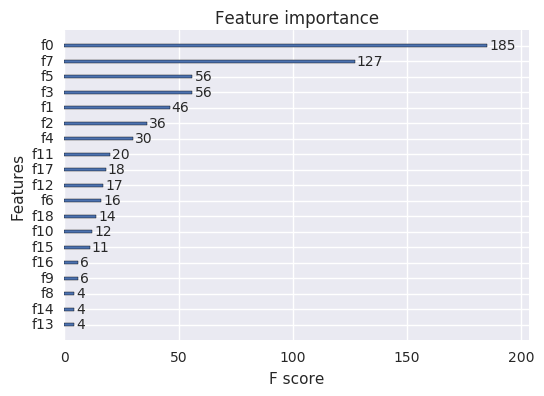

In [12]:
import matplotlib.pyplot as plt
import datetime as dt

clf = make_pipeline(StandardScaler(), XGBClassifier(nthread=-1))
start_time = dt.datetime.now()
scores = cross_val_score(clf, X.values, Y.values, cv = 10, scoring = 'accuracy', n_jobs = 1)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()*2))
print('Duración', dt.datetime.now()-start_time)

clf.fit(X.values, Y.values)
xgboost.plot_importance(clf.steps[1][1], ax=plt.gca())

### XGBOOST CON MATRIZ DE CONFUSIÓN

In [13]:
## Definimos vectores de entrenamiento y test
from sklearn.cross_validation import train_test_split 

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=100)

In [14]:
print("Number of training records: " + str(X_train.size))
print("Number of testing records : " + str(X_test.size))

Number of training records: 282245
Number of testing records : 120973


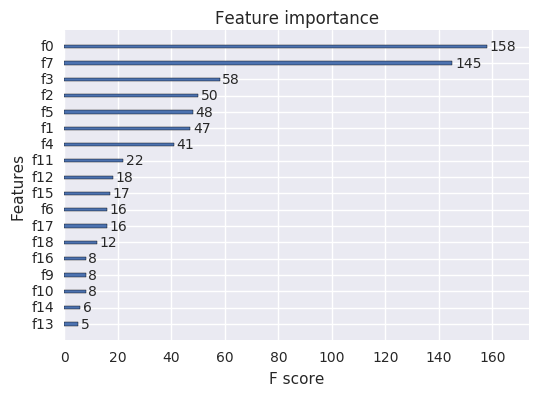

In [15]:
pipeline = Pipeline([('scaler', StandardScaler()), ('classifier', XGBClassifier())])
pipeline.fit(X_train.values, Y_train.values)
xgboost.plot_importance(pipeline.steps[1][1])

In [16]:
Y_pred = pipeline.predict(X_test.values)

tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel()

print(tn, fp, fn, tp)

2288 889 718 2472


### XGBOOST CON OPTIMIZACIÓN DE AUC

In [17]:
import numpy as np 
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from operator import itemgetter
import xgboost as xgb
from xgboost import plot_tree
import random
import time
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from numpy import genfromtxt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc,recall_score,precision_score
import datetime as dt

/gpfs/fs01/user/s57f-73edb3521eee1d-79e3f294add4/.local/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [18]:
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()

In [19]:
def get_importance(gbm, features):
    #create_feature_map(features)
    importance = gbm.get_fscore()
    importance = sorted(importance.items(), key=itemgetter(1), reverse=True)
    return importance

In [20]:
def get_features(train, test):
    trainval = list(train.columns.values)
    output = trainval
    return sorted(output)

In [21]:
def run_single(X_train, X_valid, y_train, y_valid, features, random_state=0):
    eta = 1.0
    max_depth= 6 
    subsample = 1
    colsample_bytree = 1
    min_chil_weight=1
    start_time = time.time()

    print('XGBoost params. ETA: {}, MAX_DEPTH: {}, SUBSAMPLE: {}, COLSAMPLE_BY_TREE: {}'.format(eta, max_depth, subsample, colsample_bytree))
    params = {
        "objective": "binary:logistic",
        "booster" : "gbtree",
        "eval_metric": "auc",
        "eta": eta,
        "tree_method": 'exact',
        "max_depth": max_depth,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "silent": 1,
        "min_chil_weight":min_chil_weight,
        "seed": random_state,
        #"num_class" : 22,
    }
    num_boost_round = 500
    early_stopping_rounds = 20
    test_size = 0.1

   
    
    #X_train, X_valid = train_test_split(train, test_size=test_size, random_state=random_state)
    print('Length train:', X_train.shape[0])
    print('Length valid:', X_valid.shape[0])
    #y_train = X_train[target]
    #y_valid = X_valid[target]
    dtrain = xgb.DMatrix(X_train[features], y_train, missing=-99, feature_names=features)
    dvalid = xgb.DMatrix(X_valid[features], y_valid, missing =-99, feature_names=features)

    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=True)

    print("Validating...")
    check = gbm.predict(xgb.DMatrix(X_valid[features]), ntree_limit=gbm.best_iteration+1)
    
    #area under the precision-recall curve
    score = average_precision_score(y_valid.values, check)
    print('area under the precision-recall curve: {:.6f}'.format(score))

    
    check2=check.round()
    score = precision_score(y_valid.values, check2)
    print('precision score: {:.6f}'.format(score))

    score = recall_score(y_valid.values, check2)
    print('recall score: {:.6f}'.format(score))
    
    imp = get_importance(gbm, features)
    xgboost.plot_importance(gbm)
    print('Importance array: ', imp)

    print("Predict test set... ")
    #fea = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14']
    test_prediction = gbm.predict(xgb.DMatrix(X_valid[features],missing = -99), ntree_limit=gbm.best_iteration+1)
    score = average_precision_score(y_valid.values, test_prediction)

    print('area under the precision-recall curve test set: {:.6f}'.format(score))
    
    ############################################ ROC Curve
     
    # Compute micro-average ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_valid.values, check)
    roc_auc = auc(fpr, tpr)
    #xgb.plot_importance(gbm)
    #plt.show()
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()
    ##################################################
    
    # Plot tree
    plt.figure()
    plot = plot_tree(gbm, num_trees=2, rankdir='LR')
    fig = plot.get_figure()
    fig.savefig('xgboost_tree.eps', format='eps', dpi=2000)
    plt.show()

    print('Training time: {} minutes'.format(round((time.time() - start_time)/60, 2)))
    return test_prediction, imp, gbm.best_iteration+1

In [22]:
# Any results you write to the current directory are saved as output.
start_time = dt.datetime.now()
print("Start time: ",start_time)

Start time:  2017-12-15 13:47:00.302057


['avg_uso_tarjeta', 'avg_pago_retail_mensual', 'max_pago_retail_mensual', 'std_pago_retail_mensual', 'SPEND_AMT', 'DISCOUNT_AMT', 'GENDER', 'EDAD', 'MOBILE_CONTACTABILITY', 'EMAIL_CONTACTABILITY', 'GSE_ABC1', 'GSE_C2', 'GSE_C3', 'GSE_D', 'GSE_E', 'CIVIL_STATUS_CASADO', 'CIVIL_STATUS_DIVORCIADO', 'CIVIL_STATUS_SOLTERO', 'CIVIL_STATUS_VIUDO']
Building model..  0:00:00.011784
XGBoost params. ETA: 1.0, MAX_DEPTH: 6, SUBSAMPLE: 1, COLSAMPLE_BY_TREE: 1
Length train: 14855
Length valid: 6367
[0]	train-auc:0.757463	eval-auc:0.749027
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 20 rounds.
[1]	train-auc:0.807888	eval-auc:0.793832
[2]	train-auc:0.837175	eval-auc:0.819701
[3]	train-auc:0.86979	eval-auc:0.850615
[4]	train-auc:0.894883	eval-auc:0.877624
[5]	train-auc:0.91415	eval-auc:0.896831
[6]	train-auc:0.923875	eval-auc:0.907919
[7]	train-auc:0.939856	eval-auc:0.927347
[8]	train-auc:0.953382	eval-auc:0.939905
[9

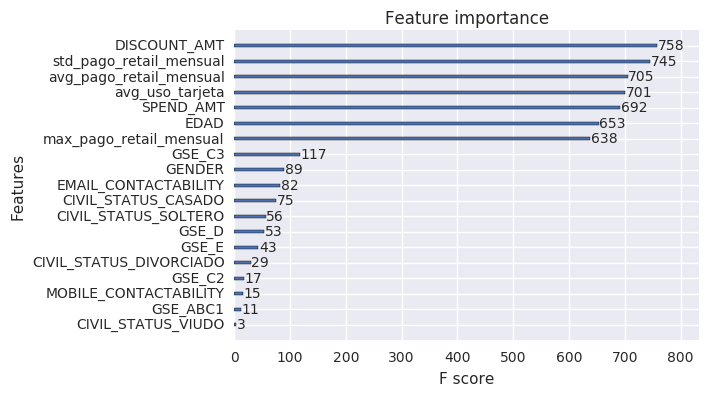

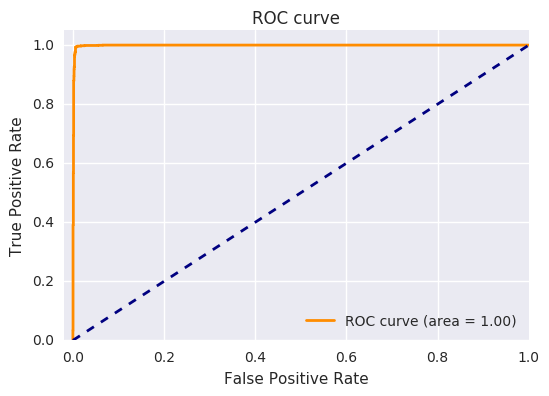

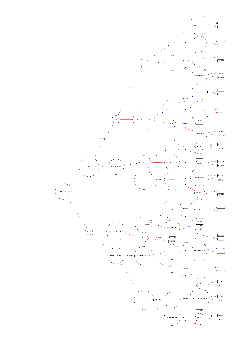

Training time: 6.25 minutes
0:06:15.131833


In [23]:
features = X_train.columns.values.tolist()
print(features)

print("Building model.. ",dt.datetime.now()-start_time)
#X_train, X_valid, y_train, y_valid, features, random_state=0
preds, imp, num_boost_rounds = run_single(X_train, X_test, Y_train, Y_test, features, 100)

 
print(dt.datetime.now()-start_time)